In [2]:
import pandas as pd
import pyreadstat  # Replaces xport
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import IntegratedGradients

# Fetch and clean the NHANES dataset using pyreadstat
def fetch_and_clean_nhanes_data():
    # Paths to NHANES datasets
    demo_path = 'data/DEMO_J.XPT'
    body_path = 'data/BMX_J.XPT'
    bp_path = 'data/BPX_J.XPT'
    health_path = 'data/HSQ_J.XPT'
    lab_path = 'data/TCHOL_J.XPT'  # For cholesterol
    smoking_path = 'data/SMQ_J.XPT'  # For smoking status

    # Load the .XPT files using pyreadstat
    demo_df, _ = pyreadstat.read_xport(demo_path)
    body_df, _ = pyreadstat.read_xport(body_path)
    bp_df, _ = pyreadstat.read_xport(bp_path)
    health_df, _ = pyreadstat.read_xport(health_path)
    lab_df, _ = pyreadstat.read_xport(lab_path)  # Load cholesterol data
    smoking_df, _ = pyreadstat.read_xport(smoking_path)  # Load smoking status

    # Merge datasets on 'SEQN' identifier
    merged_df = pd.merge(demo_df, body_df, on='SEQN', how='inner')
    merged_df = pd.merge(merged_df, bp_df, on='SEQN', how='inner')
    merged_df = pd.merge(merged_df, health_df, on='SEQN', how='inner')
    merged_df = pd.merge(merged_df, lab_df, on='SEQN', how='inner')  # Merge cholesterol data
    merged_df = pd.merge(merged_df, smoking_df, on='SEQN', how='inner')  # Merge smoking status

    # Drop rows with missing values in the columns needed for the regression task
    # BMXBMI = BMI, BPXSY1 = Systolic BP, BPXDI1 = Diastolic BP, HSD010 = Health status, RIDAGEYR = Age, RIAGENDR = sex, LBXTC = Cholesterol, SMQ020 = Smoking status
    columns_to_use = ['BMXBMI', 'BPXSY1', 'BPXDI1', 'HSD010', 'RIDAGEYR', 'RIAGENDR', 'LBXTC', 'SMQ020']
    merged_df = merged_df.dropna(subset=columns_to_use)

    # Encoding health status to binary (Good vs. Poor) using HSD010
    merged_df['HSD010'] = merged_df['HSD010'].apply(lambda x: 1 if x in [1, 2, 3] else 0)  # 1 = Good, 0 = Poor

    # Ensure smoking status is binary (yes/no)
    merged_df['SMQ020'] = merged_df['SMQ020'].apply(lambda x: 1 if x == 1 else 0)  # 1 = Smoker, 0 = Non-smoker

    return merged_df

# Prepare features and target for regression
def prepare_features_and_target(merged_df):
    # Select relevant columns for features and target
    features_all = ['BPXSY1', 'BPXDI1', 'HSD010', 'RIDAGEYR', 'RIAGENDR', 'LBXTC', 'SMQ020']  # Features
    target = 'BMXBMI'  # Using BMI as the target variable

    # Normalize numerical features
    numerical_features = ['BPXSY1', 'BPXDI1', 'RIDAGEYR', 'LBXTC']
    scaler = MinMaxScaler()
    merged_df[numerical_features] = scaler.fit_transform(merged_df[numerical_features])

    # Prepare the full feature set
    X_all = merged_df[features_all]
    y = merged_df[target]

    # Exclude sex and health status for the second model
    features_without_sex_health = ['BPXSY1', 'BPXDI1', 'RIDAGEYR', 'LBXTC', 'SMQ020']  # Exclude sex and health status
    X_without_sex_health = merged_df[features_without_sex_health]

    return X_all, X_without_sex_health, y

# Example usage
merged_df = fetch_and_clean_nhanes_data()
X_all, X_without_sex_health, y = prepare_features_and_target(merged_df)


In [13]:
# Define a simple neural network model
class DeeperNNWithBatchNorm(nn.Module):
    def __init__(self, input_dim, hidden_dim1=256, hidden_dim2=128, hidden_dim3=64, dropout_prob=0.5):
        super(DeeperNNWithBatchNorm, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_prob)
        
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_prob)
        
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn3 = nn.BatchNorm1d(hidden_dim3)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=dropout_prob)
        
        self.fc4 = nn.Linear(hidden_dim3, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)  # Apply dropout after activation
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)  # Apply dropout after activation
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)  # Apply dropout after activation
        
        x = self.fc4(x)
        return x

# Train the neural network model
def train_neural_network_model(X_train, y_train, input_dim, lr=0.0001, epochs=1000, hidden_dim=64):
    model = DeeperNNWithBatchNorm(input_dim, hidden_dim)  # Initialize the neural network
    criterion = nn.MSELoss()  # Mean squared error for regression
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Adam optimizer for better convergence
    
    # Convert training data to tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(pd.to_numeric(y_train).values, dtype=torch.float32).view(-1, 1)
    
    loss_values = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)  # Forward pass
        loss = criterion(outputs, y_train_tensor)  # Compute loss
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update the weights
        loss_values.append(loss.item())

        # Optional: Print the loss every 500 epochs to monitor
        if (epoch+1) % 500 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # Plot loss values
    plt.plot(range(epochs), loss_values)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.show()

    return model

In [4]:
def predict_model(model, X):
    model.eval()
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    with torch.no_grad():
        predictions = model(X_tensor).squeeze()
    return predictions.numpy()

# Function to evaluate the neural network regression model
def evaluate_model_regression(model, X_train, X_test, y_train, y_test, model_name):
    # Predict on training and test data
    y_train_pred = predict_model(model, X_train)
    y_test_pred = predict_model(model, X_test)

    # Calculate regression metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # Plot predictions vs true values for test data
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(f'Predictions vs True Values - Test Data ({model_name})')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line of perfect prediction
    plt.show()

    # Print regression metrics
    print(f"{model_name} - Training MSE: {train_mse:.4f}")
    print(f"{model_name} - Test MSE: {test_mse:.4f}")

In [5]:
# Train and evaluate models using the neural network
def train_and_evaluate_model():
    # Step 1: Fetch and clean the NHANES data
    merged_df = fetch_and_clean_nhanes_data()

    # Step 2: Prepare features and target for regression
    X_all, X_without_sex_health, y = prepare_features_and_target(merged_df)

    # Step 3: Split the data into training and testing sets
    X_train_hp, X_test_hp, y_train, y_test = train_test_split(X_all, y, test_size=0.3, random_state=42)
    X_train_h0, X_test_h0 = train_test_split(X_without_sex_health, test_size=0.3, random_state=42)

    print("Running regression task")

    # Train and evaluate model using all features
    print("Training and evaluating model with all features (HP)...")
    model_hp = train_neural_network_model(X_train_hp, y_train, X_train_hp.shape[1], lr=0.001, epochs=3000)
    evaluate_model_regression(model_hp, X_train_hp, X_test_hp, y_train, y_test, "h_p")

    # Train and evaluate model excluding sex and health status
    print("\nTraining and evaluating model excluding sex and health status (H0)...")
    model_h0 = train_neural_network_model(X_train_h0, y_train, X_train_h0.shape[1], lr=0.001, epochs=3000)
    evaluate_model_regression(model_h0, X_train_h0, X_test_h0, y_train, y_test, "h_0")

    # Return the necessary objects
    return X_train_hp, X_test_hp, y_train, y_test, X_train_h0, X_test_h0, model_hp, model_h0


In [6]:
def create_filters(X_test):
    """
    Create filters for the four groups: Female + Good Health, Female + Poor Health, Male + Good Health, Male + Poor Health.
    """
    filters = {}
    
    # Female + Good Health
    filters['Female + Good Health'] = (X_test['RIAGENDR'] == 2) & (X_test['HSD010'] == 1)
    
    # Female + Poor Health
    filters['Female + Poor Health'] = (X_test['RIAGENDR'] == 2) & (X_test['HSD010'] == 0)
    
    # Male + Good Health
    filters['Male + Good Health'] = (X_test['RIAGENDR'] == 1) & (X_test['HSD010'] == 1)
    
    # Male + Poor Health
    filters['Male + Poor Health'] = (X_test['RIAGENDR'] == 1) & (X_test['HSD010'] == 0)

    return filters


def evaluate_model_for_group(y_preds, y_val, group_indices, cost_function, comprehensiveness=False):
    """
    Evaluate predictions for a specific group using a custom cost function.
    Filter predictions and true values using group indices (e.g., sex + health status).
    """
    y_group_pred = y_preds[group_indices]
    y_group_val = y_val[group_indices]

    # Compute element-wise loss using the custom cost function
    individual_losses = np.array([cost_function(true, pred) for true, pred in zip(y_group_val, y_group_pred)])
    if comprehensiveness:
        individual_losses = 1 / individual_losses

    total_loss = np.mean(individual_losses)
    
    return total_loss, y_group_pred, y_group_val

def evaluate_model_by_combined_groups(y_preds, y_val, filters, cost_function, comprehensiveness=False):
    """
    Evaluate predictions based on combined filters for sex and health status.
    """
    group_losses = {}
    group_results = {}

    for group_name, group_indices in filters.items():
        group_loss, group_preds, group_true = evaluate_model_for_group(y_preds, y_val, group_indices, cost_function, comprehensiveness)
        group_losses[group_name] = group_loss
        group_results[group_name] = (group_preds, group_true)

    return group_losses, group_results


def compare_models_by_filters(y_preds_hp, y_preds_h0, X_test, y_val_hp, y_val_h0, cost_function, comprehensiveness=False):
    """
    Compare models' predictions dynamically by sex and health status using filters.
    """
    # Create filters for the groups
    filters = create_filters(X_test)

    # Evaluate total losses for both models
    total_loss_hp = np.mean([cost_function(true, pred) for true, pred in zip(y_val_hp, y_preds_hp)])
    total_loss_h0 = np.mean([cost_function(true, pred) for true, pred in zip(y_val_h0, y_preds_h0)])
    
    if comprehensiveness:
        total_loss_hp = 1 / total_loss_hp
        total_loss_h0 = 1 / total_loss_h0

    # Evaluate model h_p by group
    group_losses_hp, group_results_hp = evaluate_model_by_combined_groups(y_preds_hp, y_val_hp, filters, cost_function, comprehensiveness)

    # Evaluate model h_0 by group
    group_losses_h0, group_results_h0 = evaluate_model_by_combined_groups(y_preds_h0, y_val_h0, filters, cost_function, comprehensiveness)

    # Print results and calculate differences
    for group_name in filters:
        loss_hp = group_losses_hp[group_name]
        loss_h0 = group_losses_h0[group_name]
        loss_diff = loss_h0 - loss_hp
        print(f"Group {group_name} - Model h_p: {loss_hp:.4f}, Model h_0: {loss_h0:.4f}, Loss difference: {loss_diff:.4f}")

    print(f"Total loss h_p: {total_loss_hp:.4f}")
    print(f"Total loss h_0: {total_loss_h0:.4f}")
    print(f"Total loss difference: {total_loss_h0 - total_loss_hp:.4f}")

    return group_losses_hp, group_losses_h0




In [7]:
def individual_loss_difference(y_preds_h0, y_preds_hp, y_val_h0, y_val_hp, group_indices, cost_function, title):
    """
    Compute the loss difference between y_preds_h0 and y_preds_hp on a per-individual basis for a given group (e.g., sex + health status).
    """
    # Filter predictions and true values for the selected group
    y_preds_h0_filtered = y_preds_h0[group_indices]
    y_preds_hp_filtered = y_preds_hp[group_indices]
    y_vals_h0_filtered = y_val_h0[group_indices]
    y_vals_hp_filtered = y_val_hp[group_indices]

    if title == "Comprehensiveness":
        # Reciprocal the losses for comprehensiveness
        individual_diff = np.array([1 / cost_function(val_h0, pred_h0) - 1 / cost_function(val_hp, pred_hp)
                                    for val_h0, val_hp, pred_h0, pred_hp in zip(y_vals_h0_filtered, y_vals_hp_filtered, y_preds_h0_filtered, y_preds_hp_filtered)])
    else:
        # Compute individual element-wise losses using the custom cost function
        individual_diff = np.array([cost_function(val_h0, pred_h0) - cost_function(val_hp, pred_hp)
                                    for val_h0, val_hp, pred_h0, pred_hp in zip(y_vals_h0_filtered, y_vals_hp_filtered, y_preds_h0_filtered, y_preds_hp_filtered)])

    return individual_diff

def plot_loss_difference_histogram(y_preds_h0, y_preds_hp, X_test, y_val_h0, y_val_hp, cost_function, title):
    """
    Generate histograms of the loss difference between two sets of predictions (h0 and hp) for multiple groups using a custom element-wise cost function.
    """
    # Create filters for the groups
    filters = create_filters(X_test)

    plt.figure(figsize=(12, 6))

    for i, (group_name, group_indices) in enumerate(filters.items(), start=1):
        # Compute loss differences for each group
        group_loss_diff = individual_loss_difference(y_preds_h0, y_preds_hp, y_val_h0, y_val_hp, group_indices, cost_function, title)

        # Plot histogram for each group
        plt.subplot(2, 2, i)
        plt.hist(group_loss_diff, bins=30, alpha=0.7)
        plt.title(f'{cost_function.__name__} Difference Histogram for {group_name} ({title})')
        plt.xlabel('Difference in Loss')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()



In [8]:
# For scalars
def squared_error(true_value, pred_value):
    return (true_value - pred_value) ** 2

def zero_one_loss(true_value, pred_prob):
    pred_label = 1 if pred_prob >= 0.5 else 0
    if 0 < true_value < 1:  # If the true value is a probability, convert to binary label, this is for the case of explainers
        true_value = 1 if true_value >= 0.5 else 0
    return 1 if true_value != pred_label else 0

def binary_cross_entropy_loss(true_value, pred_prob):
    epsilon = 1e-12
    pred_prob = np.clip(pred_prob, epsilon, 1. - epsilon)
    loss = -(true_value * np.log(pred_prob) + (1 - true_value) * np.log(1 - pred_prob))
    return loss

In [9]:
# Function to apply Integrated Gradients
def explain_with_ig(model, X_test):
    ig = IntegratedGradients(model)
    
    # Convert the test set to PyTorch tensor
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    
    # Compute attributions using Integrated Gradients
    attributions, delta = ig.attribute(X_test_tensor, return_convergence_delta=True)
    # Print the shape of attributions
    print("Shape of attributions:", attributions.shape)
    
    return attributions, delta

# Function to calculate comprehensiveness
def comprehensiveness(model, X_test, attributions, top_k):
    model.eval()
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    
    # Sort attributions by importance
    top_attributions = torch.argsort(attributions, descending=True)

    # Remove top_k important features
    for i in range(X_test_tensor.size(0)):
        top_features = top_attributions[i, :top_k]
        X_test_tensor[i, top_features] = 0
    
    # Re-run the model to get new predictions with removed features
    #print("X_test_tensor shape", X_test_tensor.shape)
    with torch.no_grad():
        new_predictions = model(X_test_tensor).squeeze().numpy()

    return new_predictions

# Function to calculate(sufficiency)
def sufficiency(model, X_test, attributions, top_k):
    model.eval()
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    
    # Sort attributions by importance
    top_attributions = torch.argsort(attributions, descending=True)
    
    # Keep only top_k important features and zero out the rest
    for i in range(X_test_tensor.size(0)):
        mask = torch.zeros(X_test_tensor.size(1), dtype=torch.float32)
        top_features = top_attributions[i, :top_k]
        mask[top_features] = 1
        X_test_tensor[i] = X_test_tensor[i] * mask
    
    # Re-run the model to get new predictions with only important features
    with torch.no_grad():
        new_predictions = model(X_test_tensor).squeeze().numpy()
    
    return new_predictions


In [10]:
def plot_group_losses(ks, hp_comp_list, h0_comp_list, hp_suff_list, h0_suff_list, group_name, cost_function, row_index):
    """
    Helper function to plot comprehensiveness and sufficiency losses for a specific group.
    """
    plt.subplot(4, 2, row_index)
    plt.plot(ks, hp_comp_list, label=f'{group_name} h_p (Comp)', marker='o')
    plt.plot(ks, h0_comp_list, label=f'{group_name} h_0 (Comp)', marker='o')
    plt.xlabel('Top r Features Removed')
    plt.ylabel(f'{cost_function.__name__} Loss')
    plt.title(f'{group_name} Comprehensiveness')
    plt.legend()

    plt.subplot(4, 2, row_index + 4)  # Sufficiency plots in lower half
    plt.plot(ks, hp_suff_list, label=f'{group_name} h_p (Suff)', marker='o')
    plt.plot(ks, h0_suff_list, label=f'{group_name} h_0 (Suff)', marker='o')
    plt.xlabel('Top r Features Removed')
    plt.ylabel(f'{cost_function.__name__} Loss')
    plt.title(f'{group_name} Sufficiency')
    plt.legend()

def plot_loss_by_groups_over_ks(model_hp, model_h0, X_test_hp, X_test_h0, y_preds_hp, y_preds_h0, attributions_hp, attributions_h0, cost_function, ks):
    """
    Plot loss differences for comprehensiveness and sufficiency over the four groups (Female/Male + Good/Poor Health)
    for different top_k feature removal.
    """
    # Initialize dictionaries to store the results
    group_names = ['Female + Good Health', 'Female + Poor Health', 'Male + Good Health', 'Male + Poor Health']
    
    comp_lists_hp = {group: [] for group in group_names}
    comp_lists_h0 = {group: [] for group in group_names}
    suff_lists_hp = {group: [] for group in group_names}
    suff_lists_h0 = {group: [] for group in group_names}

    # Loop over different top_k values
    for top_k in ks:
        # Comprehensiveness and Sufficiency predictions
        comprehensiveness_preds_hp = comprehensiveness(model_hp, X_test_hp, attributions_hp, top_k)
        comprehensiveness_preds_h0 = comprehensiveness(model_h0, X_test_h0, attributions_h0, top_k)
        sufficiency_preds_hp = sufficiency(model_hp, X_test_hp, attributions_hp, top_k)
        sufficiency_preds_h0 = sufficiency(model_h0, X_test_h0, attributions_h0, top_k)

        # Filters for groups
        filters = create_filters(X_test_hp)

        # Loop over groups and calculate losses
        for group_name, group_indices in filters.items():
            # Comprehensiveness
            group_hp_comp, group_h0_comp = compare_models_by_filters(
                comprehensiveness_preds_hp, comprehensiveness_preds_h0, X_test_hp, y_preds_hp, y_preds_h0, cost_function, comprehensiveness=True)
            
            # Sufficiency
            group_hp_suff, group_h0_suff = compare_models_by_filters(
                sufficiency_preds_hp, sufficiency_preds_h0, X_test_hp, y_preds_hp, y_preds_h0, cost_function)
            
            # Store results
            comp_lists_hp[group_name].append(group_hp_comp[group_name])
            comp_lists_h0[group_name].append(group_h0_comp[group_name])
            suff_lists_hp[group_name].append(group_hp_suff[group_name])
            suff_lists_h0[group_name].append(group_h0_suff[group_name])

    # Plot comprehensiveness and sufficiency for each group
    plt.figure(figsize=(14, 12))
    
    for i, group_name in enumerate(group_names, start=1):
        plot_group_losses(ks, comp_lists_hp[group_name], comp_lists_h0[group_name],
                          suff_lists_hp[group_name], suff_lists_h0[group_name], group_name, cost_function, i)

    plt.tight_layout()
    plt.show()

Running regression task
Training and evaluating model with all features (HP)...
Epoch [500/3000], Loss: 82.6764
Epoch [1000/3000], Loss: 72.6647
Epoch [1500/3000], Loss: 69.8505
Epoch [2000/3000], Loss: 65.0670
Epoch [2500/3000], Loss: 65.5071
Epoch [3000/3000], Loss: 62.6006


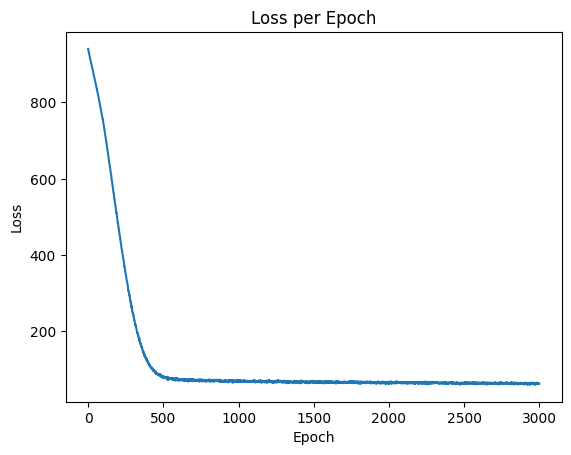

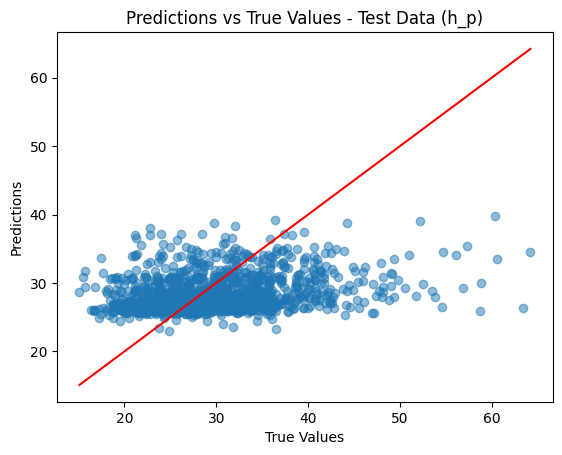

h_p - Training MSE: 43.6657
h_p - Test MSE: 48.4625

Training and evaluating model excluding sex and health status (H0)...
Epoch [500/3000], Loss: 84.2401
Epoch [1000/3000], Loss: 77.3948
Epoch [1500/3000], Loss: 75.6861
Epoch [2000/3000], Loss: 69.9103
Epoch [2500/3000], Loss: 67.9446
Epoch [3000/3000], Loss: 65.6881


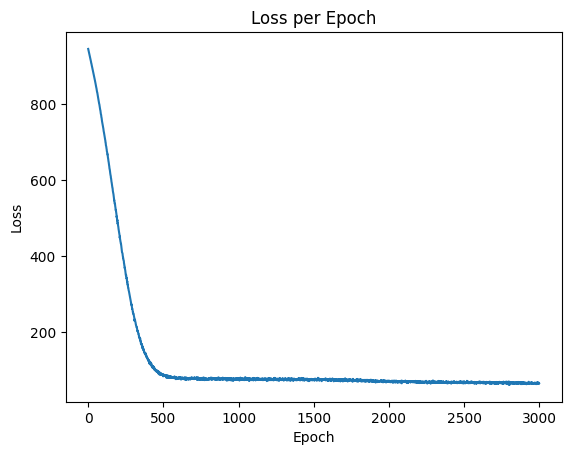

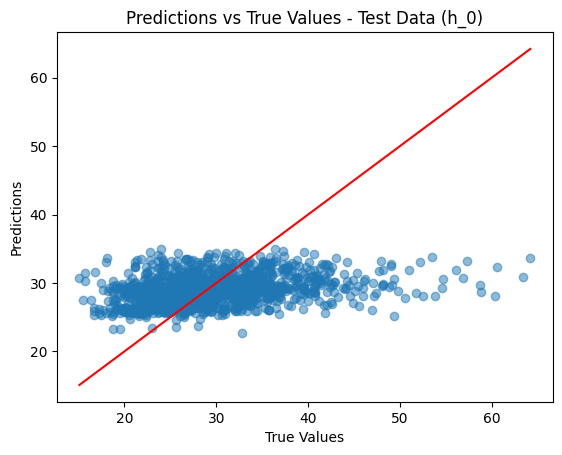

h_0 - Training MSE: 47.4417
h_0 - Test MSE: 46.7728


In [14]:
# Step 1: Train and evaluate the models
X_train_hp_reg, X_test_hp_reg, y_train_reg, y_test_reg, X_train_h0_reg, X_test_h0_reg, model_hp_reg, model_h0_reg = train_and_evaluate_model()

For test data:
Group Female + Good Health - Model h_p: 63.2782, Model h_0: 59.9402, Loss difference: -3.3380
Group Female + Poor Health - Model h_p: 75.0938, Model h_0: 65.7534, Loss difference: -9.3404
Group Male + Good Health - Model h_p: 37.7003, Model h_0: 48.1536, Loss difference: 10.4533
Group Male + Poor Health - Model h_p: 58.8157, Model h_0: 57.8855, Loss difference: -0.9303
Total loss h_p: 54.6096
Total loss h_0: 55.9913
Total loss difference: 1.3817
For training data:
Number of females + good health:  1141
Number of females + poor health:  390
Number of males + good health:  1159
Number of males + poor health:  333
Group Female + Good Health - Model h_p: 44.8828, Model h_0: 46.4611, Loss difference: 1.5784
Group Female + Poor Health - Model h_p: 53.6160, Model h_0: 62.8562, Loss difference: 9.2402
Group Male + Good Health - Model h_p: 27.7110, Model h_0: 39.1255, Loss difference: 11.4145
Group Male + Poor Health - Model h_p: 34.3766, Model h_0: 38.3801, Loss difference: 4.00

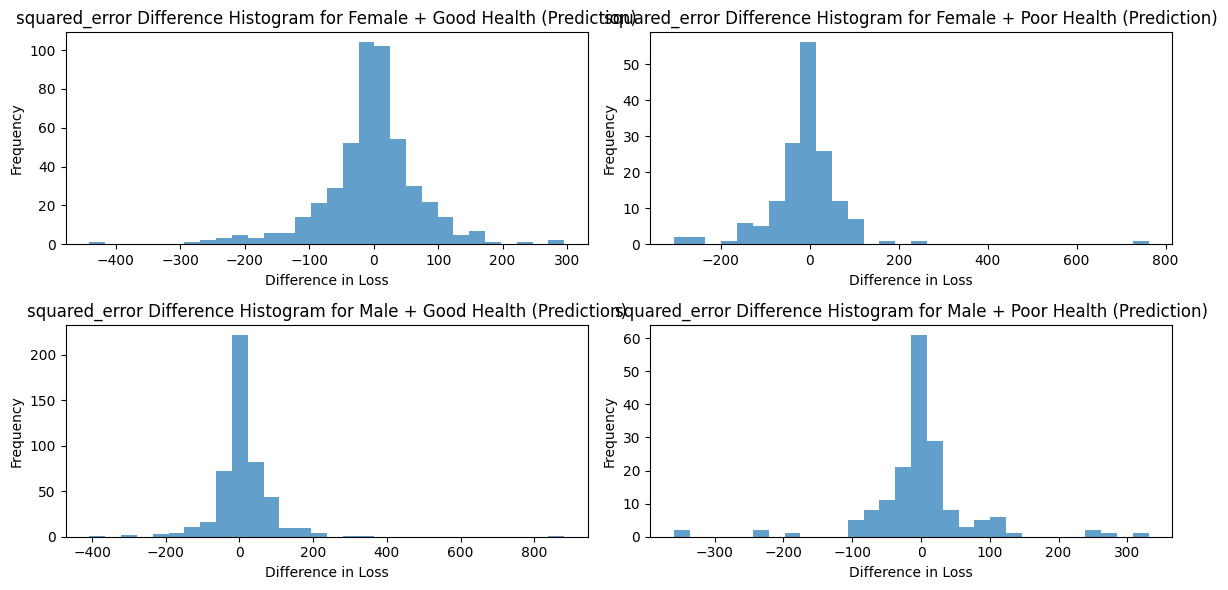

In [35]:
# Step 2: Generate predictions for both models
y_preds_hp_reg = predict_model(model_hp_reg, X_test_hp_reg)
y_preds_h0_reg = predict_model(model_h0_reg, X_test_h0_reg)

# Use the same true labels for both models
y_test_hp_reg = y_test_reg
y_test_h0_reg = y_test_reg

# Step 3: Compare models by sex and health status using regression cost function (mean squared error)
print("For test data:")
filters = create_filters(X_test_hp_reg)
print("Number of females + good health: ", (filters['Female + Good Health']).sum())
print("Number of females + poor health: ", (filters['Female + Poor Health']).sum())
print("Number of males + good health: ", (filters['Male + Good Health']).sum())
print("Number of males + poor health: ", (filters['Male + Poor Health']).sum())
group_losses_hp, group_losses_h0 = compare_models_by_filters(y_preds_hp_reg, y_preds_h0_reg, X_test_hp_reg, y_test_hp_reg, y_test_h0_reg, squared_error, comprehensiveness=False)

print("For training data:")
#preds
y_preds_hp_train_reg = predict_model(model_hp_reg, X_train_hp_reg)
y_preds_h0_train_reg = predict_model(model_h0_reg, X_train_h0_reg)

# Display number of individuals in each group (based on sex + health status)
filters_train = create_filters(X_train_hp_reg)
print("Number of females + good health: ", (filters_train['Female + Good Health']).sum())
print("Number of females + poor health: ", (filters_train['Female + Poor Health']).sum())
print("Number of males + good health: ", (filters_train['Male + Good Health']).sum())
print("Number of males + poor health: ", (filters_train['Male + Poor Health']).sum())

#vals
y_train_hp_reg = y_train_reg
y_train_h0_reg = y_train_reg

# Compare models for training data
group_losses_hp_train, group_losses_h0_train = compare_models_by_filters(y_preds_hp_train_reg, y_preds_h0_train_reg, X_train_hp_reg, y_train_hp_reg, y_train_h0_reg, squared_error, comprehensiveness=False)

# Step 4: Plot loss difference histograms for model predictions using mean squared error
plot_loss_difference_histogram(y_preds_h0_reg, y_preds_hp_reg, X_test_hp_reg, y_test_h0_reg, y_test_hp_reg, squared_error, "Prediction")

In [36]:
# Step 5: Generate explanations with Integrated Gradients for test and training data
attributions_hp_reg, _ = explain_with_ig(model_hp_reg, X_test_hp_reg)
attributions_h0_reg, _ = explain_with_ig(model_h0_reg, X_test_h0_reg)

# Generate explanations for training data
attributions_hp_train_reg, _ = explain_with_ig(model_hp_reg, X_train_hp_reg)
attributions_h0_train_reg, _ = explain_with_ig(model_h0_reg, X_train_h0_reg)

Shape of attributions: torch.Size([1296, 7])
Shape of attributions: torch.Size([1296, 5])
Shape of attributions: torch.Size([3023, 7])
Shape of attributions: torch.Size([3023, 5])


For testing data explainer


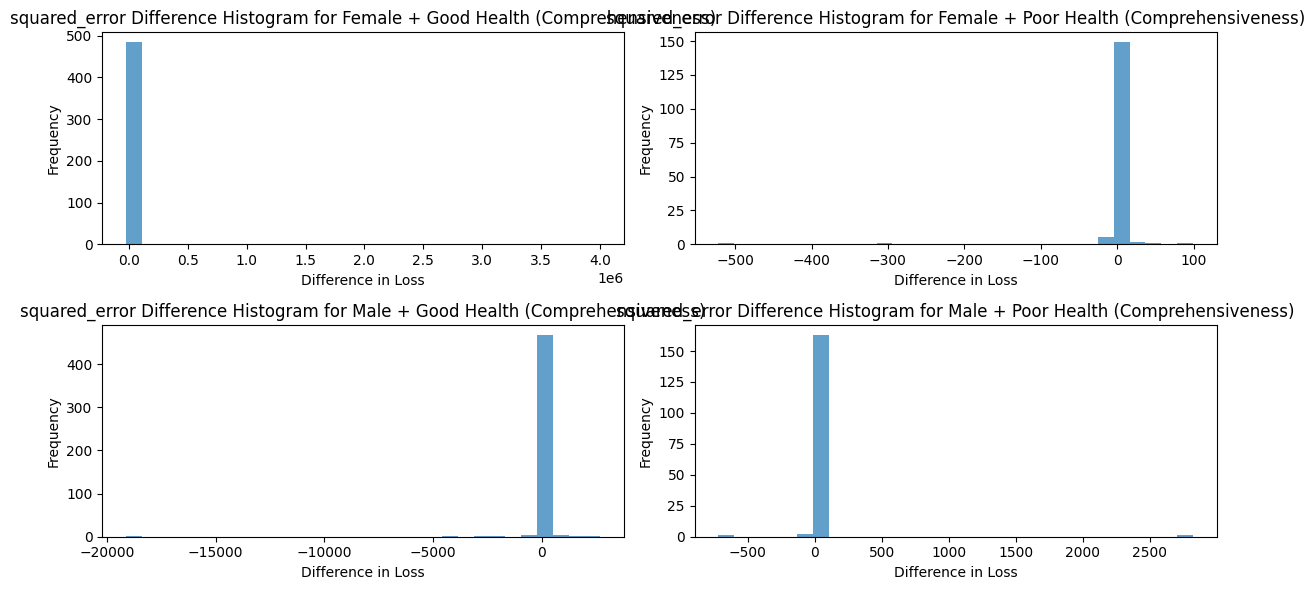

Group Female + Good Health - Model h_p: 61.4302, Model h_0: 8263.4095, Loss difference: 8201.9793
Group Female + Poor Health - Model h_p: 5.6513, Model h_0: 1.7738, Loss difference: -3.8775
Group Male + Good Health - Model h_p: 73.9238, Model h_0: 22.7070, Loss difference: -51.2168
Group Male + Poor Health - Model h_p: 5.0478, Model h_0: 18.1746, Loss difference: 13.1267
Total loss h_p: 0.0058
Total loss h_0: 0.0154
Total loss difference: 0.0097


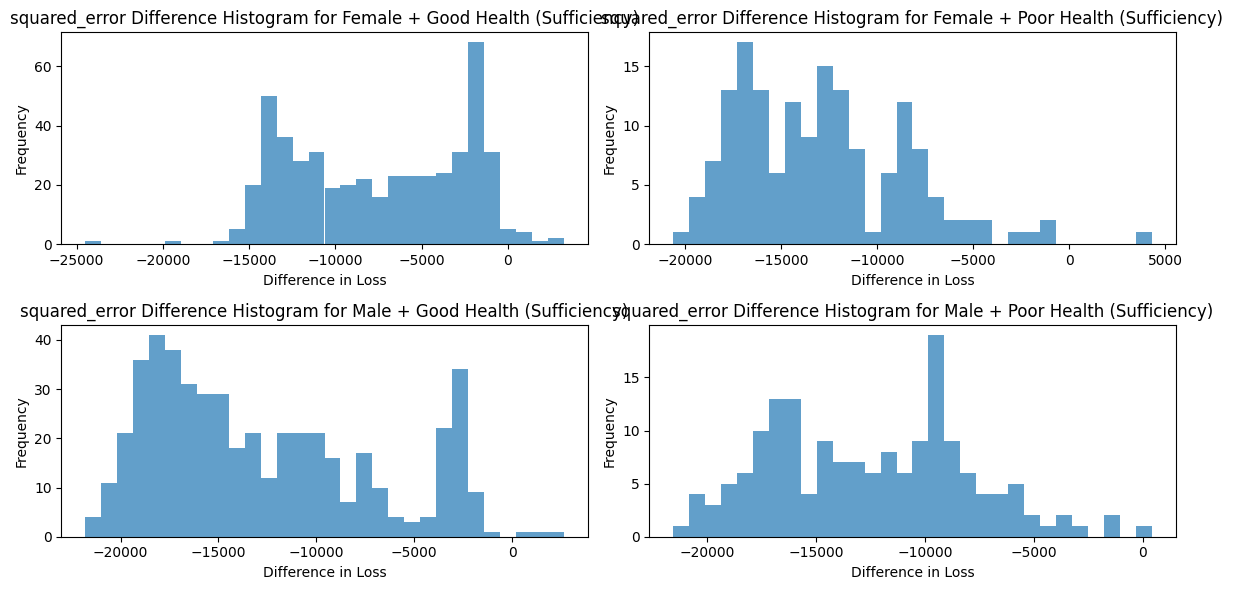

Group Female + Good Health - Model h_p: 7685.8693, Model h_0: 129.3399, Loss difference: -7556.5294
Group Female + Poor Health - Model h_p: 13265.6262, Model h_0: 360.7495, Loss difference: -12904.8767
Group Male + Good Health - Model h_p: 12957.4017, Model h_0: 137.8204, Loss difference: -12819.5813
Group Male + Poor Health - Model h_p: 12739.1268, Model h_0: 204.9759, Loss difference: -12534.1509
Total loss h_p: 10994.5705
Total loss h_0: 170.8224
Total loss difference: -10823.7481
For training data explainer
Group Female + Good Health - Model h_p: 19.8210, Model h_0: 55.4281, Loss difference: 35.6072
Group Female + Poor Health - Model h_p: 8.0601, Model h_0: 15.9688, Loss difference: 7.9087
Group Male + Good Health - Model h_p: 2105.7282, Model h_0: 957.0589, Loss difference: -1148.6692
Group Male + Poor Health - Model h_p: 5.9278, Model h_0: 5.4098, Loss difference: -0.5180
Total loss h_p: 0.0062
Total loss h_0: 0.0152
Total loss difference: 0.0090
Group Female + Good Health - Mode

/tmp/ipykernel_4167712/2759633200.py:33: RuntimeWarning: divide by zero encountered in divide
  individual_losses = 1 / individual_losses


Group Female + Good Health - Model h_p: 57.1914, Model h_0: inf, Loss difference: inf
Group Female + Poor Health - Model h_p: 0.6267, Model h_0: inf, Loss difference: inf
Group Male + Good Health - Model h_p: 24.4111, Model h_0: inf, Loss difference: inf
Group Male + Poor Health - Model h_p: 8.4024, Model h_0: inf, Loss difference: inf
Total loss h_p: 0.0166
Total loss h_0: 0.0170
Total loss difference: 0.0004
Group Female + Good Health - Model h_p: 12228.6641, Model h_0: 43.6105, Loss difference: -12185.0536
Group Female + Poor Health - Model h_p: 13263.0017, Model h_0: 49.1985, Loss difference: -13213.8032
Group Male + Good Health - Model h_p: 14778.5805, Model h_0: 55.8806, Loss difference: -14722.7000
Group Male + Poor Health - Model h_p: 14017.1491, Model h_0: 52.6868, Loss difference: -13964.4623
Total loss h_p: 13539.1043
Total loss h_0: 50.0523
Total loss difference: -13489.0521
Group Female + Good Health - Model h_p: 57.1914, Model h_0: inf, Loss difference: inf
Group Female +

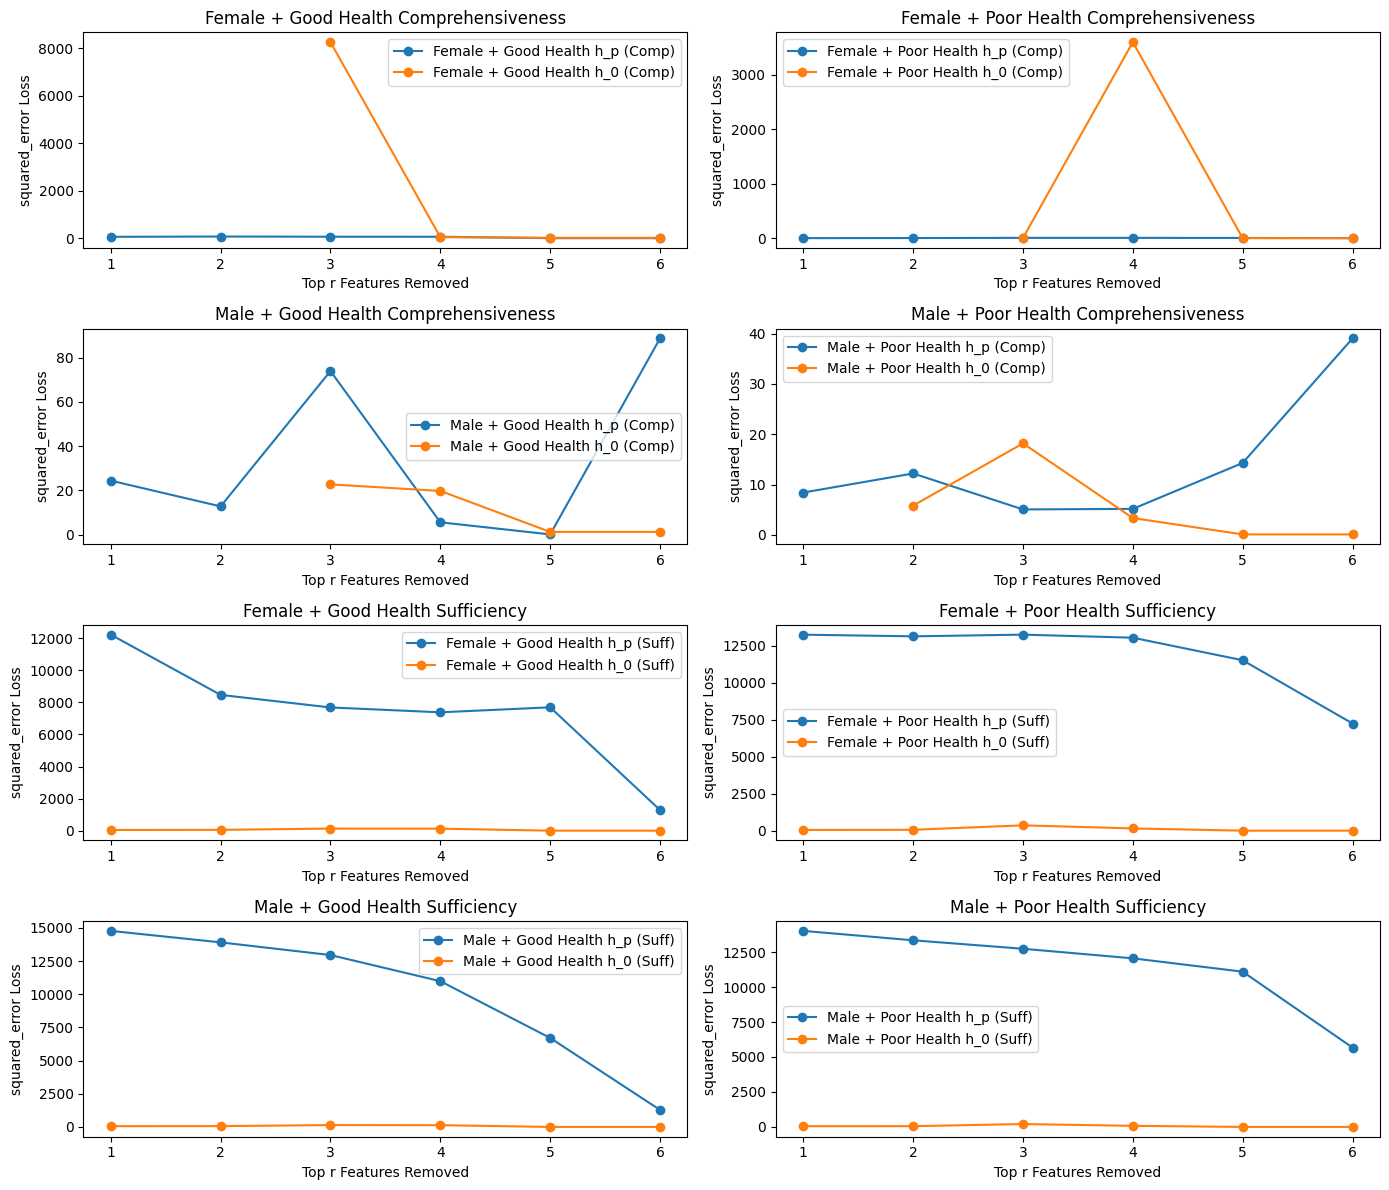

In [41]:
top_k = 3  # Adjust the number of top features to remove

# Step 6: Analyze comprehensiveness for test data
print("For testing data explainer")
comprehensiveness_preds_hp_reg = comprehensiveness(model_hp_reg, X_test_hp_reg, attributions_hp_reg, top_k)
comprehensiveness_preds_h0_reg = comprehensiveness(model_h0_reg, X_test_h0_reg, attributions_h0_reg, top_k)

# Plot loss differences for comprehensiveness
plot_loss_difference_histogram(comprehensiveness_preds_h0_reg, comprehensiveness_preds_hp_reg, X_test_hp_reg, y_preds_h0_reg, y_preds_hp_reg, squared_error, "Comprehensiveness")

# Compare models for comprehensiveness
group_losses_hp, group_losses_h0 = compare_models_by_filters(comprehensiveness_preds_hp_reg, comprehensiveness_preds_h0_reg, X_test_hp_reg, y_preds_hp_reg, y_preds_h0_reg, squared_error, comprehensiveness=True)

# Step 7: Analyze sufficiency for test data
sufficiency_preds_hp_reg = sufficiency(model_hp_reg, X_test_hp_reg, attributions_hp_reg, top_k)
sufficiency_preds_h0_reg = sufficiency(model_h0_reg, X_test_h0_reg, attributions_h0_reg, top_k)

# Plot loss differences for sufficiency
plot_loss_difference_histogram(sufficiency_preds_h0_reg, sufficiency_preds_hp_reg, X_test_hp_reg, y_preds_h0_reg, y_preds_hp_reg, squared_error, "Sufficiency")

# Compare models for sufficiency
group_losses_hp, group_losses_h0 = compare_models_by_filters(sufficiency_preds_hp_reg, sufficiency_preds_h0_reg, X_test_hp_reg, y_preds_hp_reg, y_preds_h0_reg, squared_error, comprehensiveness=False)

# Step 8: Analyze comprehensiveness for training data
print("For training data explainer")
comprehensiveness_preds_hp_train_reg = comprehensiveness(model_hp_reg, X_train_hp_reg, attributions_hp_train_reg, top_k)
comprehensiveness_preds_h0_train_reg = comprehensiveness(model_h0_reg, X_train_h0_reg, attributions_h0_train_reg, top_k)

# Compare models for comprehensiveness on training data
group_losses_hp_train, group_losses_h0_train = compare_models_by_filters(comprehensiveness_preds_hp_train_reg, comprehensiveness_preds_h0_train_reg, X_train_hp_reg, y_preds_hp_train_reg, y_preds_h0_train_reg, squared_error, comprehensiveness=True)

# Step 9: Analyze sufficiency for training data
sufficiency_preds_hp_train_reg = sufficiency(model_hp_reg, X_train_hp_reg, attributions_hp_train_reg, top_k)
sufficiency_preds_h0_train_reg = sufficiency(model_h0_reg, X_train_h0_reg, attributions_h0_train_reg, top_k)

# Compare models for sufficiency on training data
group_losses_hp_train, group_losses_h0_train = compare_models_by_filters(sufficiency_preds_hp_train_reg, sufficiency_preds_h0_train_reg, X_train_hp_reg, y_preds_hp_train_reg, y_preds_h0_train_reg, squared_error, comprehensiveness=False)

# Step 10: Plot loss differences for various values of k
ks = [1, 2, 3, 4, 5, 6]  # Example range of k values
plot_loss_by_groups_over_ks(model_hp_reg, model_h0_reg, X_test_hp_reg, X_test_h0_reg, y_preds_hp_reg, y_preds_h0_reg, attributions_hp_reg, attributions_h0_reg, squared_error, ks)
